# Sloan Digital Sky Survey Classification
## Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS

### About the notebook

In this notebook we will try to classify observations of space in three different categories: stars, galaxies, quasars.

We are using data from the Sloan Digital Sky Survey (**Release 14**). 

### About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. 

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

**For more information about this awesome project - please visit their website:**

http://www.sdss.org/

![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

### Importing Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150
 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics



## Data Acquisition

I you wish to find out more information about how to get data from the SDSS see their Data Access Guide:

http://www.sdss.org/dr14/data_access/

The query you can use to access the data is the following :

### Query

**SELECT TOP 10000** <br/>
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.run, p.rerun, p.camcol, p.field,  <br/>
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid  <br/>
**FROM** PhotoObj **AS** p <br/>
   **JOIN** SpecObj **AS** s **ON** s.bestobjid = p.objid <br/>
**WHERE** <br/>
   p.u **BETWEEN** 0 **AND** 19.6 <br/>
   **AND** g **BETWEEN** 0 **AND** 20 <br/>



The above query joins two tables (actually views): The image table (PhotoObj) which contains all image objects and the spectral table (SpecObj) which contains corresponding spectral data. 

### Feature Description

#### View "PhotoObj"
* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

* run = Run Number
* rereun = Rerun Number
* camcol = Camera column
* field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:
- **run** number, which identifies the specific scan,
- the camera column, or "**camcol**," a number from 1 to 6, identifying the scanline within the run, and
- the **field** number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
- An additional number, **rerun**, specifies how the image was processed. 

#### View "SpecObj"

* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)

The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

**Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

In [4]:
df = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/boosting_model_eval/Skyserver_SQL2_27_2018 6_51_39 PM.csv')

## Data exploration and preprocessing

In [5]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [6]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [7]:
df.run.value_counts()

756     3060
752     2086
1345     915
1350     540
1140     527
745      453
1035     396
1412     347
1302     246
1331     245
1231     245
1334     212
1239     197
1336     182
1404     137
1045     112
1402      49
308       31
1411      10
1356       4
727        4
1119       1
1332       1
Name: run, dtype: int64

In [9]:
cols_drop = ['objid', "run", 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'fiberid']
df = df.drop(cols_drop, axis = 1)
df.head()

,ra,dec,u,g,r,i,z,class,redshift,mjd
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,54922
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,51615
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,52023
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,54922
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,54922


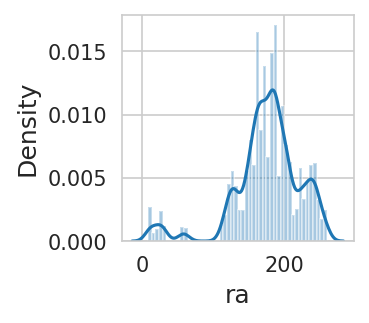

In [11]:
plt.figure(figsize=(2,2))
sns.distplot(df.ra)
plt.show()

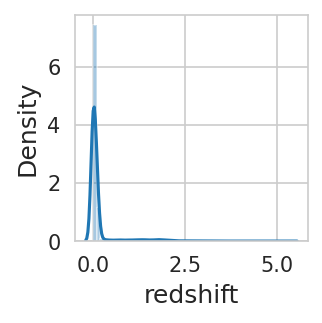

In [12]:
plt.figure(figsize=(2,2))
sns.distplot(df.redshift)
plt.show()

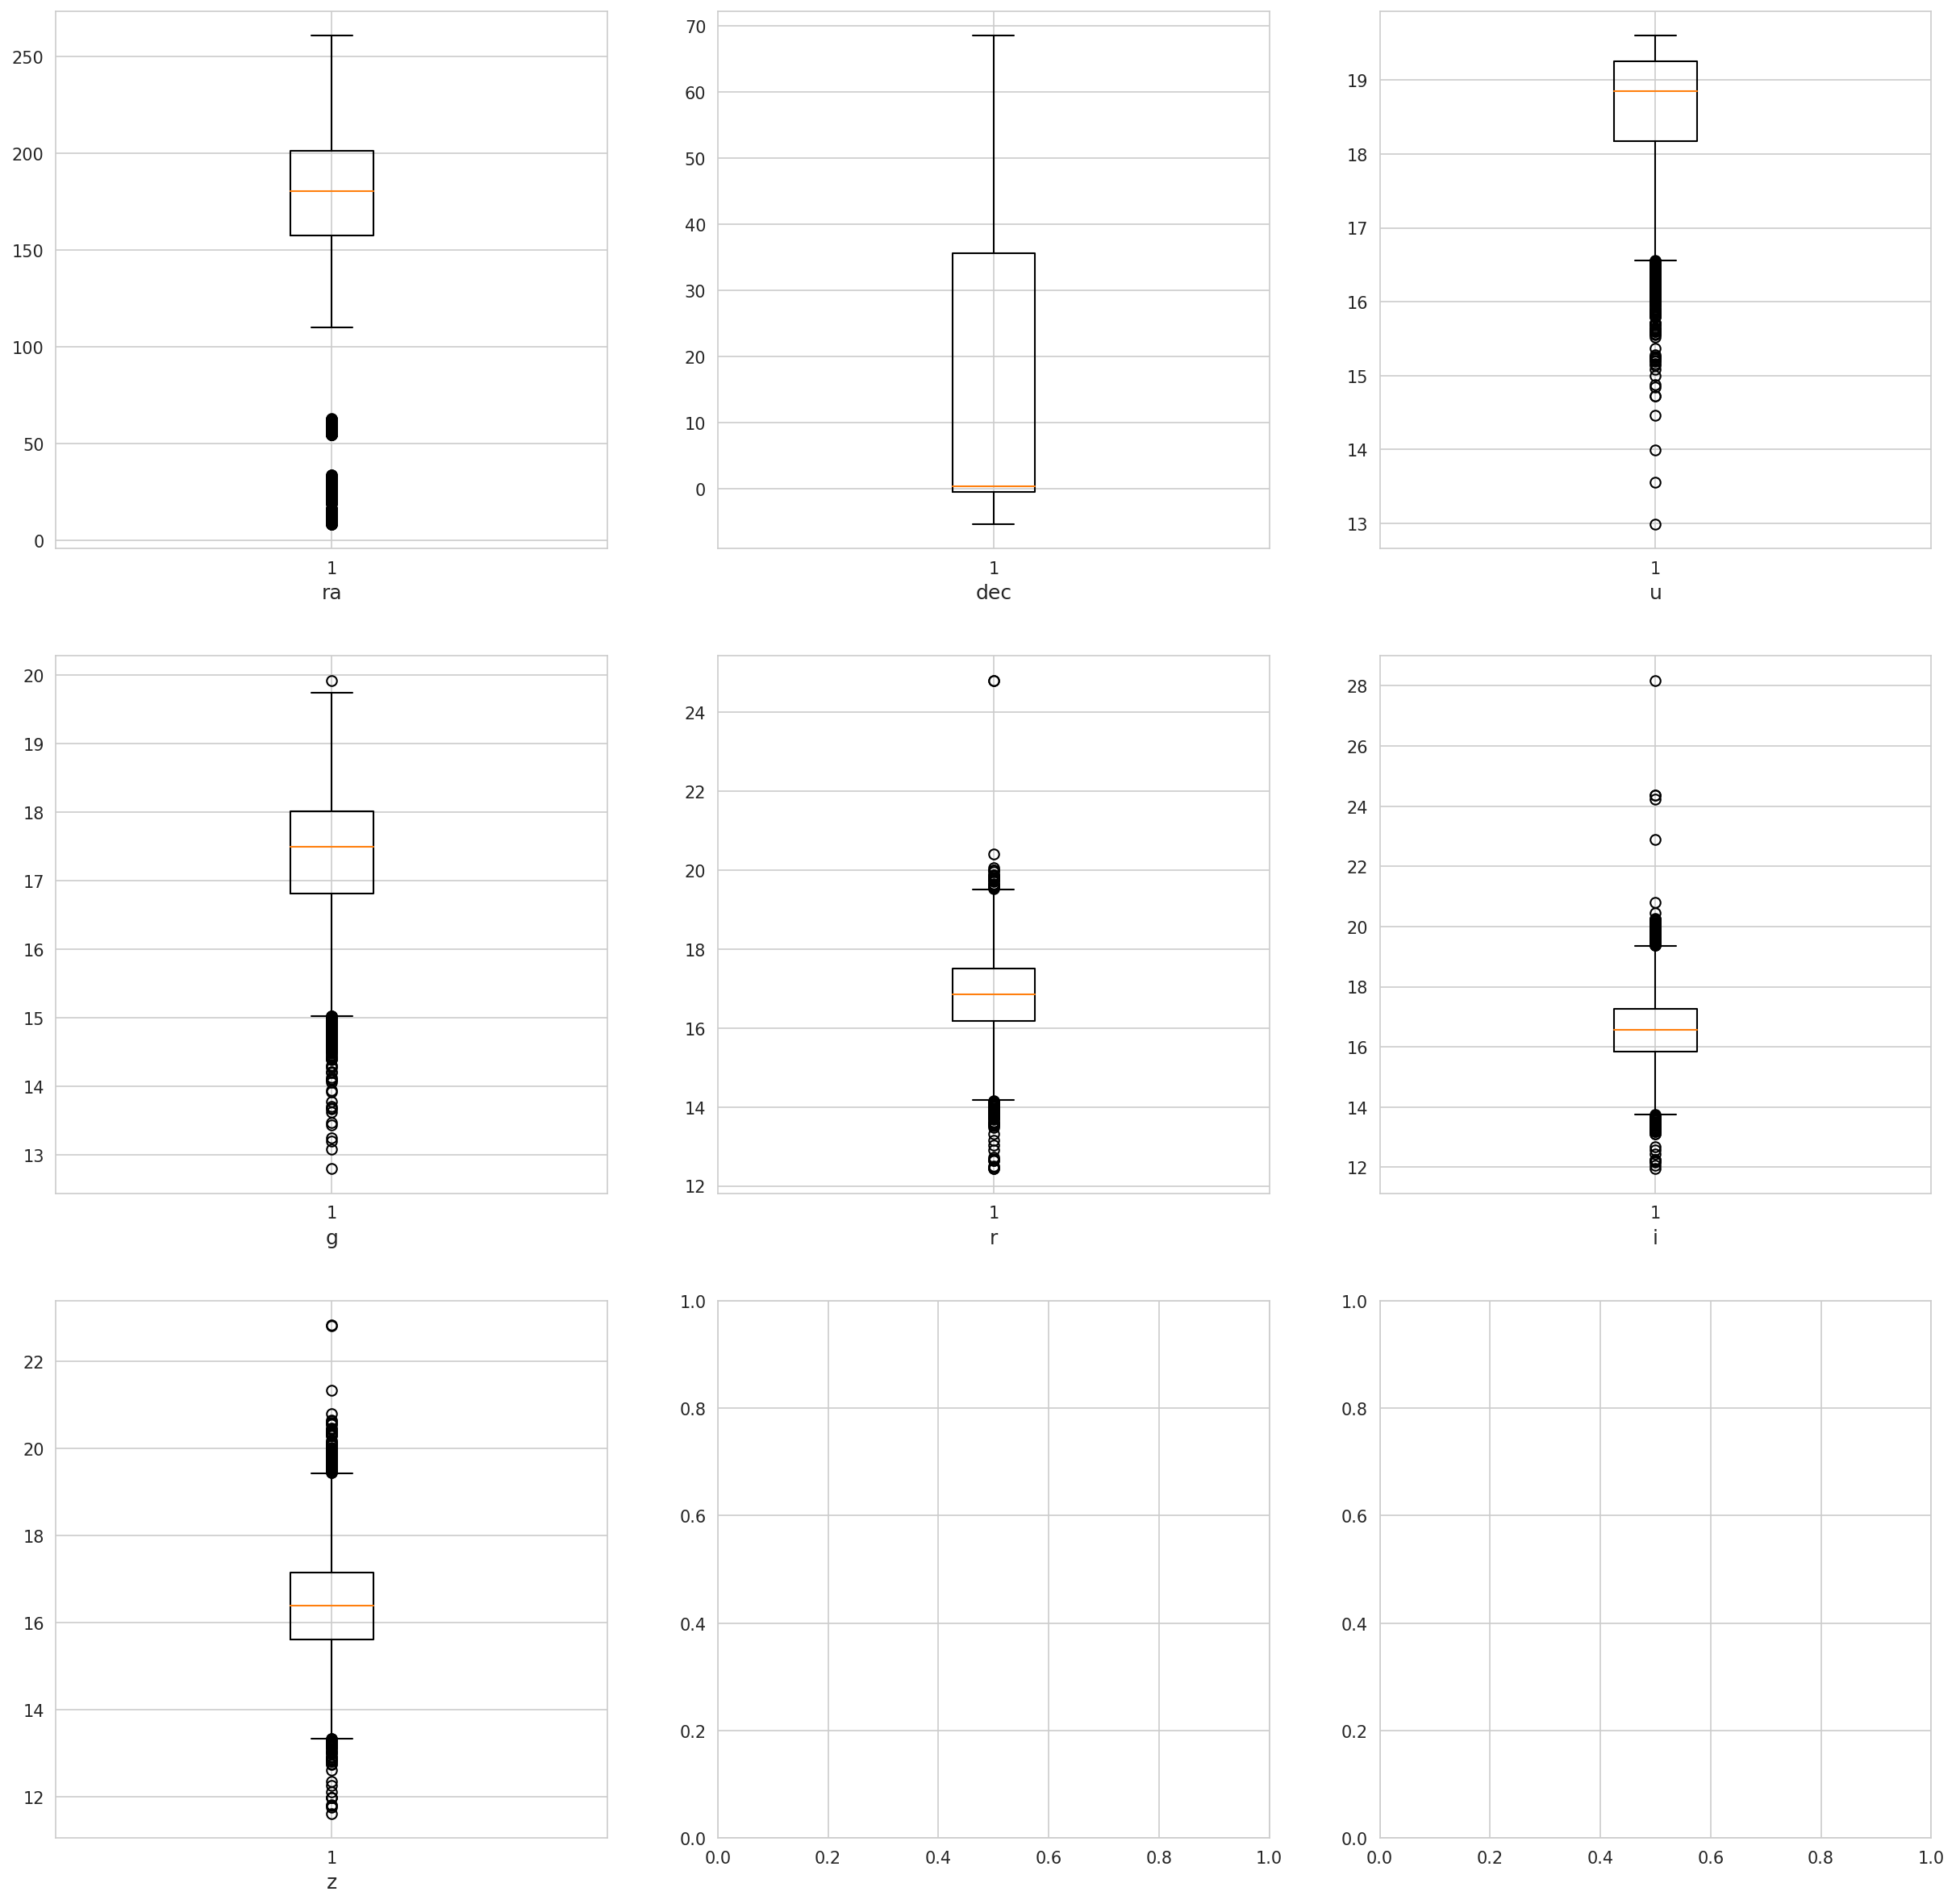

In [13]:
metrics = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']
fig, ax = plt.subplots(3,3, figsize = (20,20))
for i, axi in enumerate(ax.flat):
    if i > 6:
        pass
    else:
        x = (df.loc[:,metrics[i]]).tolist()
        axi.boxplot(x)
        axi.set(xlabel=metrics[i])

In [14]:
# Separate data in X and Y and then split intro train and test
Y = df.loc[:, "class"]
X = df.drop('class', axis = 1)
print(X.head())
print(Y.head())

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

           ra       dec         u         g         r         i         z  \
0  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   

   redshift    mjd  
0 -0.000009  54922  
1 -0.000055  51615  
2  0.123111  52023  
3 -0.000111  54922  
4  0.000590  54922  
0      STAR
1      STAR
2    GALAXY
3      STAR
4      STAR
Name: class, dtype: object
Dividing into train and test sets...
...Done.



In [15]:
scaler = StandardScaler()
print("Performing preprocessings on train set...")
print(X_train[0:5])
X_train = scaler.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5])
X_test = scaler.transform(X_test)
print('...Done.')
print(X_test[0:5])

Performing preprocessings on train set...
              ra        dec         u         g         r         i         z  \
749   210.309557  -0.760298  19.38266  18.81006  18.72689  18.71282  18.47746   
9986  131.050203  51.391819  19.37797  17.91853  17.10964  16.68906  16.36748   
7608  194.066814  68.223561  18.86498  17.57919  16.99713  16.61292  16.38148   
8477   19.506273  14.134257  18.91735  17.66109  16.85672  16.42755  16.09988   
1216  146.247636   0.718493  17.41267  17.09897  17.39865  17.65552  17.87561   

      redshift    mjd  
749   2.511341  55631  
9986  0.093830  51873  
7608  0.066298  51988  
8477  0.057130  51821  
1216  0.000125  55563  
...Done.
[[ 0.72366813 -0.61552858  0.91506763  1.52286141  1.7679204   1.88310226
   1.71364328  5.94894989  1.78163146]
 [-0.93200133  1.45864878  0.90940562  0.57854142  0.25384137  0.09724927
  -0.04242427 -0.13316719 -0.70888053]
 [ 0.38436919  2.12807541  0.29009804  0.21910815  0.14850885  0.03006005
  -0.03077253 -0.2

## AdaBoost

In [16]:
classifier = AdaBoostClassifier()

print("Training model...")
classifier.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print("Accuracy on train set: {:.3}".format(accuracy_score(Y_train, Y_train_pred)))
print("Accuracy on test set: {:.3}".format(accuracy_score(Y_test, Y_test_pred)))

Training model...
...Done.
Predictions on training set...
...Done.
['QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'STAR']

Predictions on test set...
...Done.
['STAR' 'STAR' 'STAR' 'STAR' 'STAR']

Accuracy on train set: 0.982
Accuracy on test set: 0.976


In [19]:
scores = cross_val_score(classifier, X, Y, cv=10)
predictions = cross_val_predict(classifier, X, Y, cv=10)

In [20]:
scores

array([0.786, 0.911, 0.713, 0.723, 0.748, 0.825, 0.671, 0.973, 0.879,
       0.777])

In [21]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[500,1000,2000]}

grid_ada = GridSearchCV(classifier, params, cv=5, verbose = 2)
grid_fit_ada = grid_ada.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=500, total=   8.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ................................. n_estimators=500, total=   8.4s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   8.4s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   8.4s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   8.5s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  16.9s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  16.8s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  16.9s
[CV] n_estimators=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.9min finished


In [22]:
grid_fit_ada.best_params_

{'n_estimators': 500}

In [23]:
best_estimator = grid_fit_ada.best_estimator_

In [24]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_estimator.predict(X_train)
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_estimator.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()

print("Accuracy on train set: {:.3}".format(accuracy_score(Y_train, Y_train_pred)))
print("Accuracy on test set: {:.3}".format(accuracy_score(Y_test, Y_test_pred)))
print()

Predictions on training set...
...Done.
['QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'STAR']

Predictions on test set...
...Done.
['STAR' 'STAR' 'STAR' 'STAR' 'STAR']

Accuracy on train set: 0.982
Accuracy on test set: 0.976



In [25]:
scores = cross_val_score(best_estimator, X, Y, cv=10)
scores 

array([0.839, 0.911, 0.788, 0.755, 0.682, 0.803, 0.752, 0.973, 0.812,
       0.852])

## Decision Tree

In [26]:
tree_regressor = DecisionTreeClassifier(max_depth = 1) #because max_depth of adaboost decision tree is by default 1 
tree_regressor.fit(X_train, Y_train)

print("score Tree max depth 1 train {}".format(tree_regressor.score(X_train, Y_train)))
print("score Tree max depth 1 test {}".format(tree_regressor.score(X_test, Y_test)))

score Tree max depth 1 train 0.912125
score Tree max depth 1 test 0.9125


In [27]:
scores = cross_val_score(tree_regressor, X, Y, cv=10)
scores

array([0.914, 0.91 , 0.912, 0.913, 0.91 , 0.915, 0.91 , 0.911, 0.912,
       0.913])

## XGBoost

In [28]:
clf_xgb = XGBClassifier(max_depth=1)
clf_xgb.fit(X_train, Y_train)

print("score XGBoost default train {}".format(clf_xgb.score(X_train, Y_train)))
print("score XGBoost default test {}".format(clf_xgb.score(X_test, Y_test)))

[15:58:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score XGBoost default train 0.99325
score XGBoost default test 0.988


In [29]:
scores = cross_val_score(clf_xgb, X, Y, cv=10)
scores

[15:58:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

array([0.993, 0.993, 0.991, 0.992, 0.991, 0.99 , 0.986, 0.984, 0.991,
       0.988])

In [30]:
scores.std()

0.002844292530665581

## Conclusion

XGBoost and Decision Tree performed equally well, while AdaBoost presented a lot of variability in the cross_val_score.